Files already downloaded and verified


/home/yalluri/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yalluri/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting DCGAN Training...
Epoch [1/50] | Loss D: 0.4478, Loss G: 2.1969, FID: 424.3278
Epoch [2/50] | Loss D: 0.4940, Loss G: 1.7291, FID: 406.5483
Epoch [3/50] | Loss D: 0.5344, Loss G: 1.5147, FID: 316.8075
Epoch [4/50] | Loss D: 0.5768, Loss G: 1.3061, FID: 273.9889
Epoch [5/50] | Loss D: 0.5415, Loss G: 1.4401, FID: 201.2649
Epoch [6/50] | Loss D: 0.5565, Loss G: 1.3245, FID: 251.3894
Epoch [7/50] | Loss D: 0.5773, Loss G: 1.2150, FID: 225.8497
Epoch [8/50] | Loss D: 0.5875, Loss G: 1.1572, FID: 250.2116
Epoch [9/50] | Loss D: 0.5888, Loss G: 1.1455, FID: 274.1290
Epoch [10/50] | Loss D: 0.5839, Loss G: 1.1600, FID: 213.6624
Epoch [11/50] | Loss D: 0.5861, Loss G: 1.1531, FID: 219.1800
Epoch [12/50] | Loss D: 0.5827, Loss G: 1.1548, FID: 240.2470
Epoch [13/50] | Loss D: 0.5804, Loss G: 1.1627, FID: 210.1439
Epoch [14/50] | Loss D: 0.5717, Loss G: 1.1896, FID: 222.5449
Epoch [15/50] | Loss D: 0.5632, Loss G: 1.2084, FID: 198.5085
Epoch [16/50] | Loss D: 0.5568, Loss G: 1.2219, FID:

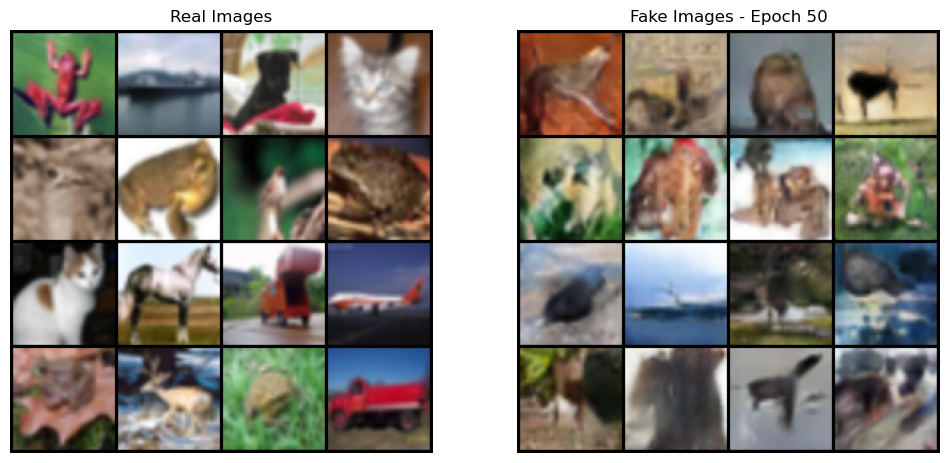

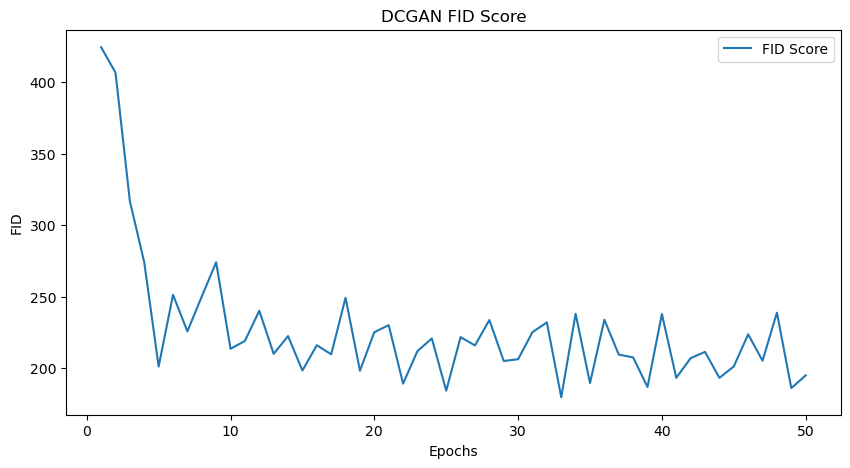

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
from torchvision.transforms.functional import resize
import numpy as np
from scipy import linalg

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_path = "./cifar10_data"
dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 4 * 4 * 512),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, channels_img):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(channels_img, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def calculate_fid(real_images, fake_images, inception_model, batch_size=64):
    def preprocess_images(images):
        images = (images + 1) / 2  
        images = resize(images, [299, 299])
        return images

    def get_activations(images, model):
        activations = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            batch = preprocess_images(batch)
            with torch.no_grad():
                act = model(batch)
            activations.append(act.view(batch.size(0), -1).cpu().numpy())
        return np.concatenate(activations, axis=0)

    real_activations = get_activations(real_images, inception_model)
    fake_activations = get_activations(fake_images, inception_model)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return np.sum(diff ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)

noise_dim = 100
channels_img = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(noise_dim, channels_img).to(device)
disc = Discriminator(channels_img).to(device)

gen.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) else None)
disc.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) else None)

optimizer_g = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion = nn.BCELoss()
num_epochs = 50
fixed_noise = torch.randn(64, noise_dim).to(device)
fid_scores = []
inception_model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
inception_model.fc = nn.Identity()

loss_g_list, loss_d_list = [], []

print("Starting DCGAN Training...")
for epoch in range(1, num_epochs + 1):
    loss_g_epoch, loss_d_epoch = 0.0, 0.0
    for real_images, _ in data_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = gen(noise)

        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  
        fake_labels = torch.zeros(batch_size, 1).to(device)

        disc_real = disc(real_images)
        disc_fake = disc(fake_images.detach())
        loss_d_real = criterion(disc_real, real_labels)
        loss_d_fake = criterion(disc_fake, fake_labels)
        loss_d = (loss_d_real + loss_d_fake) / 2
        disc.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        gen_fake = disc(fake_images)
        loss_g = criterion(gen_fake, real_labels)
        gen.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        loss_g_epoch += loss_g.item()
        loss_d_epoch += loss_d.item()

    loss_g_list.append(loss_g_epoch / len(data_loader))
    loss_d_list.append(loss_d_epoch / len(data_loader))

    gen.eval()
    with torch.no_grad():
        fake_images_sample = gen(fixed_noise).detach()
    fid_score = calculate_fid(real_images[:64], fake_images_sample, inception_model)
    fid_scores.append(fid_score)
    gen.train()

    print(f"Epoch [{epoch}/{num_epochs}] | Loss D: {loss_d_list[-1]:.4f}, Loss G: {loss_g_list[-1]:.4f}, FID: {fid_score:.4f}")

    if epoch == num_epochs :
        with torch.no_grad():
            fake_images_sample = gen(fixed_noise).detach().cpu()
        real_images_sample = real_images[:16].detach().cpu()

        real_grid = make_grid(real_images_sample, normalize=True, nrow=4)
        fake_grid = make_grid(fake_images_sample[:16], normalize=True, nrow=4)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(real_grid.permute(1, 2, 0))
        plt.title("Real Images")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(fake_grid.permute(1, 2, 0))
        plt.title(f"Fake Images - Epoch {epoch}")
        plt.axis("off")

        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fid_scores) + 1), fid_scores, label="FID Score")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("DCGAN FID Score")
plt.legend()
plt.show()

In [27]:
fid_filename = "./npy_files/dcgan_fid_scores.npy"

In [28]:
def save_fid_values(fid_values, filename="./fid_scores.npy"):
    np.save(filename, np.array(fid_values))
    print(f"FID values saved to {filename}.")

In [30]:
save_fid_values(fid_scores, fid_filename)

FID values saved to ./npy_files/dcgan_fid_scores.npy.


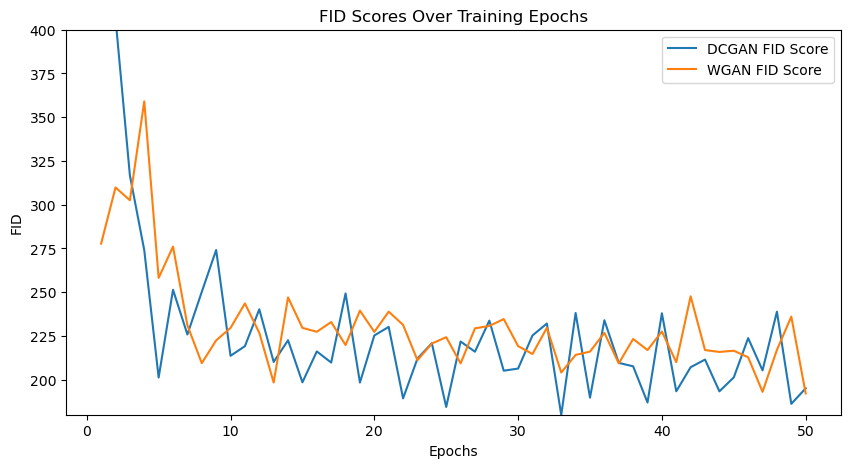

In [40]:
fid_filename1 = "./npy_files/dcgan_fid_scores.npy"
fid_filename2 = "./npy_files/wgan_fid_scores.npy"
fid_filename3 = "./npy_files/acgan_fid_scores.npy"

try:
    fid_scores1 = np.load(fid_filename1)
    fid_scores2 = np.load(fid_filename2)
    fid_scores3 = np.load(fid_filename3)
except FileNotFoundError:
    print(f"No file found at {fid_filename}. Make sure the file exists.")
    fid_scores = []

if len(fid_scores) > 0:
    plt.figure(figsize=(10, 5))
    plt.ylim(180,400)
    plt.plot(range(1, len(fid_scores) + 1), fid_scores1, label="DCGAN FID Score")
    plt.plot(range(1, len(fid_scores) + 1), fid_scores2, label="WGAN FID Score")
    plt.xlabel("Epochs")
    plt.ylabel("FID")
    plt.title("FID Scores Over Training Epochs")
    plt.legend()
    plt.show()
else:
    print("No FID values available to plot.")

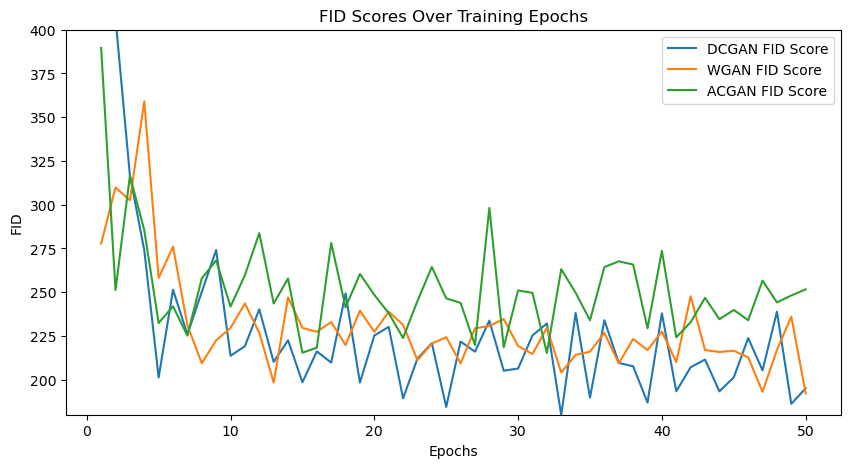

In [43]:
plt.figure(figsize=(10, 5))
plt.ylim(180,400)
plt.plot(range(1, len(fid_scores) + 1), fid_scores1, label="DCGAN FID Score")
plt.plot(range(1, len(fid_scores) + 1), fid_scores2, label="WGAN FID Score")
plt.plot(range(1, len(fid_scores) + 1), fid_scores3, label="ACGAN FID Score")

plt.xlabel("Epochs")
plt.ylabel("FID")
plt.title("FID Scores Over Training Epochs")
plt.legend()
plt.show()
